tobac example: Tracking of precipitation features
===
This example notebook demonstrates the use of tobac to track precipitation features from isolated deep convective clouds.

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme.

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

**Import necessary python libraries:**

In [1]:
# Import a range of python libraries used in this notebook:
import datetime
import shutil
from pathlib import Path
from six.moves import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.6.2


In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Download example data:**

Actual download has to be performed only once for all example notebooks!

In [4]:
data_out=Path('../')

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_Precip.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_Precip.nc'))

**Load Data from downloaded file:**

In [6]:
Precip = xr.open_dataset(data_file[0]).surface_precipitation_average

In [7]:
#display information about the iris cube containing the surface precipitation data:
display(Precip)

<xarray.DataArray 'surface_precipitation_average' (time: 47, south_north: 198,
                                                   west_east: 198)> Size: 7MB
[1842588 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 376B 2013-06-19T20:05:00 ... 2013-06-1...
  * south_north  (south_north) int64 2kB 281 282 283 284 285 ... 475 476 477 478
  * west_east    (west_east) int64 2kB 281 282 283 284 285 ... 475 476 477 478
    latitude     (south_north, west_east) float32 157kB ...
    longitude    (south_north, west_east) float32 157kB ...
    x            (west_east) float64 2kB ...
    y            (south_north) float64 2kB ...
    x_0          (west_east) int64 2kB ...
    y_0          (south_north) int64 2kB ...
Attributes:
    long_name:  surface_precipitation_average
    units:      mm h-1

In [8]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

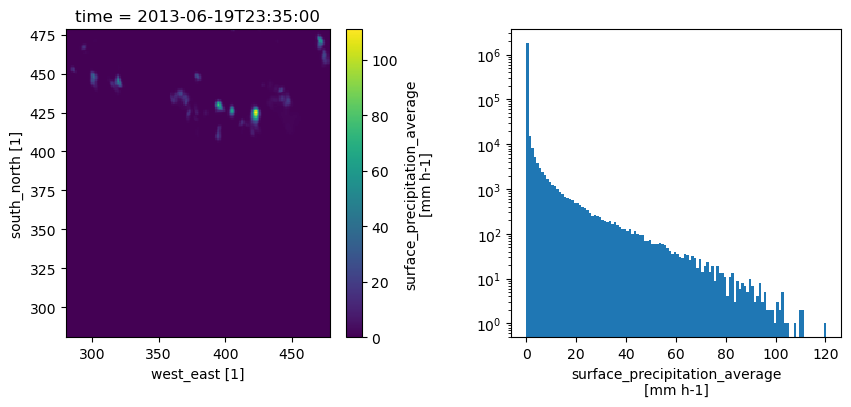

In [9]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
Precip[42].plot(ax=ax1)

ax2 = plt.subplot(1,2,2)
Precip.plot(ax=ax2, bins=120)
plt.yscale("log")

plt.subplots_adjust(wspace=0.35)

**Feature detection:**

Feature detection is perfomed based on surface precipitation field and a range of thresholds

In [10]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_distance']=0
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[1,2,3,4,5,10,15] #mm/h
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=3

In [11]:
# get temporal and spation resolution of the data
dxy,dt=tobac.get_spacings(Precip)

In [12]:
# Feature detection based on based on surface precipitation field and a range of thresholds
print('starting feature detection based on multiple thresholds')
Features=tobac.feature_detection_multithreshold(Precip,dxy,**parameters_features)
print('feature detection done')
Features.to_hdf(savedir / 'Features.h5','table')
print('features saved')

starting feature detection based on multiple thresholds


feature detection done
features saved


In [13]:
Features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,south_north,west_east,latitude,longitude,x,y,x_0,y_0
0,0,1,50.065727,139.857477,9,1,1,2013-06-19 20:05:00,2013-06-19 20:05:00,331.065727,420.857477,29.846362,-94.172015,210678.738492,165782.863285,420.857477,331.065727
1,0,15,120.527119,172.500325,4,1,2,2013-06-19 20:05:00,2013-06-19 20:05:00,401.527119,453.500325,30.166929,-93.996892,227000.162468,201013.559414,453.500325,401.527119
2,0,18,126.779273,145.368401,15,1,3,2013-06-19 20:05:00,2013-06-19 20:05:00,407.779273,426.368401,30.196499,-94.139960,213434.200454,204139.636582,426.368401,407.779273
3,0,34,111.611369,155.452030,4,2,4,2013-06-19 20:05:00,2013-06-19 20:05:00,392.611369,436.452030,30.126871,-94.087317,218476.015240,196555.684682,436.452030,392.611369
4,0,35,111.765231,164.938866,8,2,5,2013-06-19 20:05:00,2013-06-19 20:05:00,392.765231,445.938866,30.127221,-94.037226,223219.433218,196632.615461,445.938866,392.765231


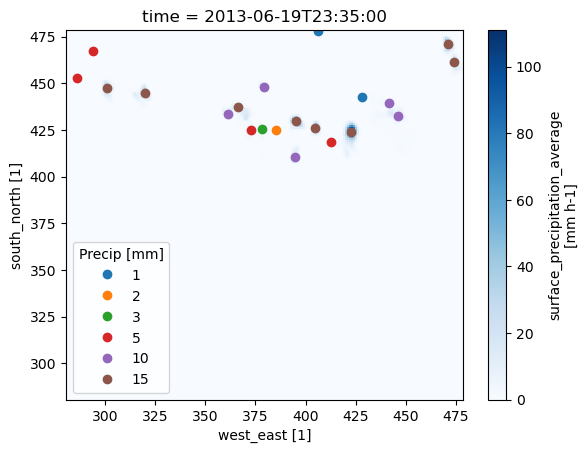

In [14]:
frame=42
Precip[frame].plot(cmap="Blues")
points = {
    threshold:plt.plot(ft.west_east, ft.south_north, "o")[0]
    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
}
plt.legend(list(points.values()), list(points.keys()), title="Precip [mm]")

**Segmentation:**

Segmentation is performed based on a watershedding and a threshold value:

In [15]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=1  # mm/h mixing ratio

In [16]:
# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on surface precipitation')
Mask, Features_Precip = tobac.segmentation_2D(Features, Precip, dxy, **parameters_segmentation)
print('segmentation based on surface precipitation performed, start saving results to files')
Mask.to_netcdf(savedir / 'Mask_Segmentation_OLR.nc', encoding={"segmentation_mask":{"zlib":True, "complevel":4}})
Features_Precip.to_hdf(savedir / 'Features_Precip.h5', 'table')
print('segmentation surface precipitation performed and saved')


Starting segmentation based on surface precipitation


segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved


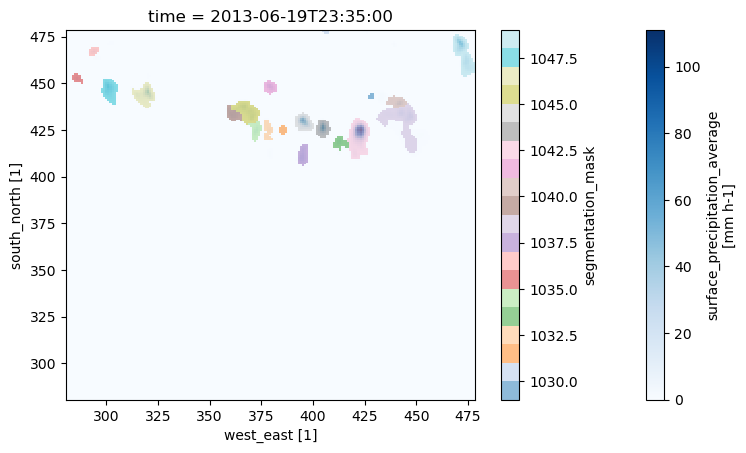

In [17]:
plt.figure(figsize=(8.8, 4.8))
Precip[frame].plot(cmap="Blues", cbar_kwargs=dict(pad=0.1))
Mask[frame].where(Mask[frame]>0).plot(cmap="tab20", alpha=0.5)

**Trajectory linking:**

Trajectory linking is performed using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [18]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10


In [19]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:
Track=tobac.linking_trackpy(Features, Precip, dt=dt, dxy=dxy, **parameters_linking)
Track.to_hdf(savedir / 'Track.h5', 'table')


Frame 46: 18 trajectories present.


**Visualistation:**

    

In [20]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent=[-95,-93.8,29.5,30.6]        

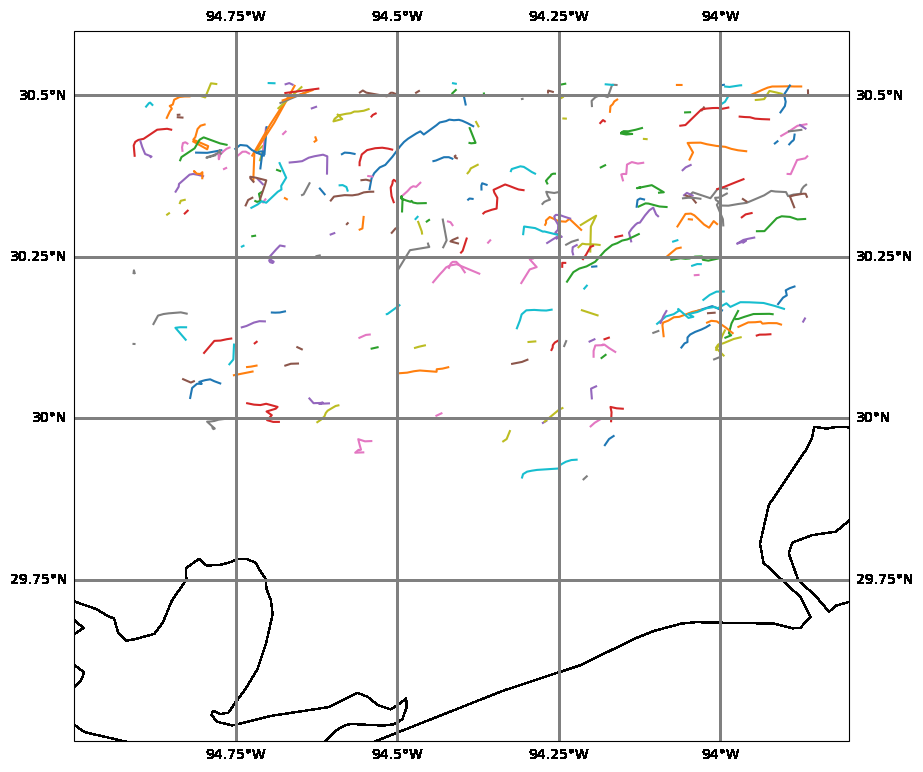

In [21]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map, ax_map=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track, axis_extent=axis_extent, axes=ax_map)

Text(0, 0.5, 'counts')

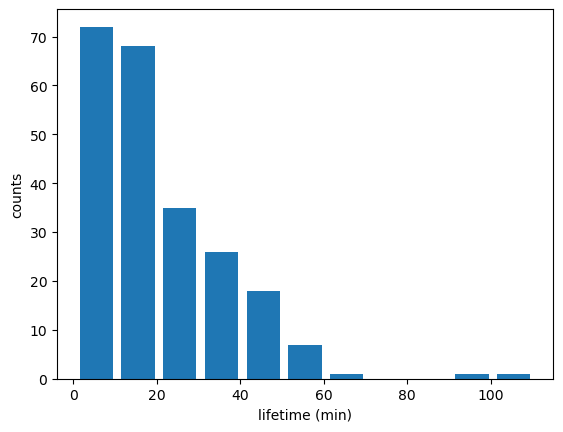

In [22]:
# Lifetimes of tracked features:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,120,10),density=False,width_bar=8)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         

In [23]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_tobac=tobac.animation_mask_field(
    Track, Features, Precip, Mask,
    axis_extent=axis_extent,
    vmin=0, vmax=60, extend='both', cmap='Blues',
    plot_outline=True, plot_marker=True, marker_track='x',
    plot_number=True, plot_features=True
)

In [24]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>